# Human Activity Recognition

1. [Introduction](#Introduction)
2. [Data exploration](#Data-exploration)
3. [Reproducing the paper's results](#Reproducing-the-paper's-results)
4. [Feature generation](#Feature-generation)
5. [Naive Bayes](#Naive-Bayes)
6. [Logistic regression](#Logistic-regression)
7. [Decision tree](#Decision-tree)
8. [Random forest](#Random-forest)
9. [K-nearest neighbours](#K-nearest-neighbours)
10. [Feedforward neural network](#Feedforward-neural-network)
11. [Convolutional neural network](#Convolutional-neural-network)
12. [Conclusion](#Conclusion)

## Introduction

Smartphones, smartwatches and other mobile technology identify their orientation in space through the use of accelerometers. This information can be used, for example, to align the screen depending on the direction the device is held. 

The data collected by an accelerometer can also be used to identify the activity that a user is performing, such as jogging or sitting. In this project I use accelerometer records from the WISDM (Wireless Sensor Data Mining) [dataset](http://www.cis.fordham.edu/wisdm/dataset.php) to classify different daily activities.

The dataset contains accelerometer data from a group of people as they perform the following activities: walking, jogging, ascending stairs, descending stairs, sitting and standing. They carried a smartphone in their front trousers pocket while performing these activities for certain periods of time. Acceleration in all three spatial dimensions was recorded twenty times per second. More details on this dataset can be found on the original [paper](http://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf).

In the following section we explore the data, fill missing values and visualize some features. Afther that I reproduce the original paper's results and develop my own fetaures to use in various learning algorithms.

## Data exploration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import tensorflow as tf
from tensorflow import keras
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.io import arff
import matplotlib.pyplot as plt
%matplotlib inline
colours=['#F15152','#5F7FAB','#329F5B','#486C9F','#315A93','#1A4887','#04367C']

I start by loading the raw WISDM dataset.

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
raw = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)

In [3]:
raw.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


The z-axis column is not in the right format. Next I remove the semicolon and convert the values to float numbers.

In [5]:
raw['z-axis'] = raw['z-axis'].str.replace(';', '').astype(float)

Now I check if there are any missing values in the dataset.

In [6]:
raw.isna().sum()

user         0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64

There is only one missing value, which can be safely removed.

In [7]:
raw.dropna(inplace=True)

Let's visualise the amount of readings for each activity:

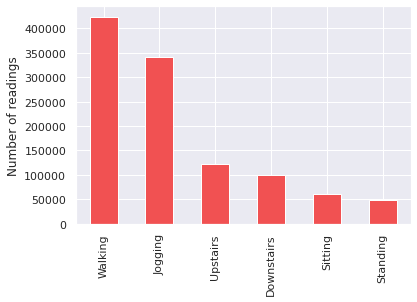

In [8]:
raw['activity'].value_counts().plot(kind='bar', color=colours[0])
plt.ylabel('Number of readings');

There is more data for walking and jogging. This imbalance can potentially affect the performance of the learning algorithms.

The next plot shows the distribution of data recorded amongst users.

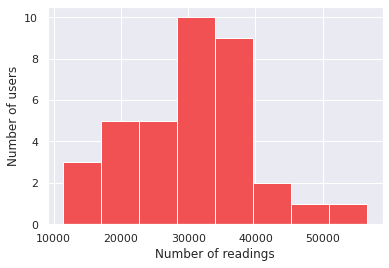

In [9]:
raw['user'].value_counts().hist(bins=8, color=colours[0])
plt.xlabel('Number of readings')
plt.ylabel('Number of users');

Now I plot some examples for each activity to see how different they look like.

In [10]:
def plot_example(activity, df, start=200, end=400):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][start:end].reset_index()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(data['x-axis'],color=colours[0], label='x-axis')
    ax.plot(data['y-axis'],color=colours[1], label='y-axis')
    ax.plot(data['z-axis'],color=colours[2], label='z-axis')
    ax.set_title(activity, fontsize=15)
    ax.set_xlabel('Reading number')
    ax.set_ylabel('Acceleration [m/s$^2$]')
    ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

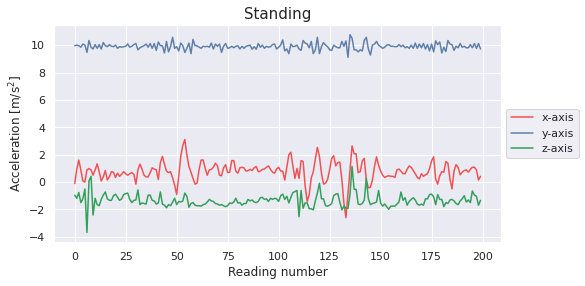

In [11]:
plot_example('Standing', raw)

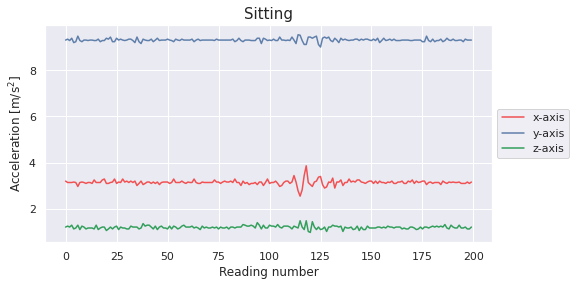

In [12]:
plot_example('Sitting', raw)

For standing and sitting, the sensors are stable and there is no periodic behaviour.

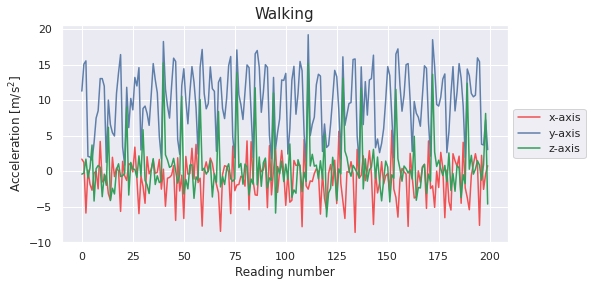

In [13]:
plot_example('Walking', raw)

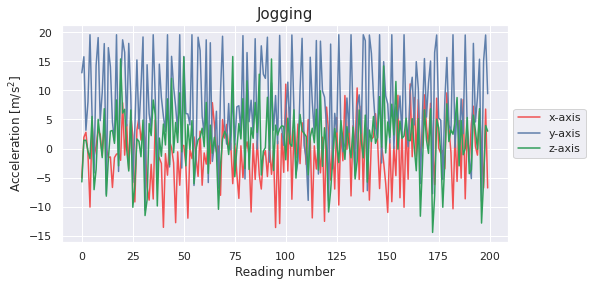

In [14]:
plot_example('Jogging', raw)

Walking and jogging show periodic patterns, with jogging having a higher frequency.

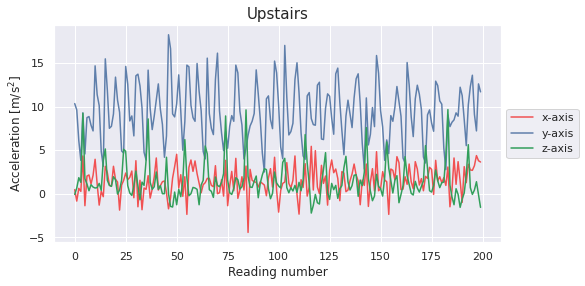

In [15]:
plot_example('Upstairs', raw)

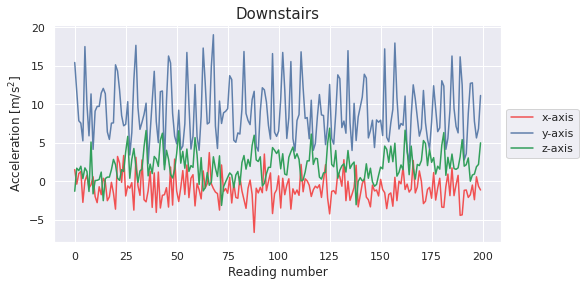

In [16]:
plot_example('Downstairs', raw)

Ascending and descending stairs also present periodic patterns. At least visually it seems difficult to distinguish between walking, going upstairs and going downstairs.

Now let's see what the whole data for sitting looks like:

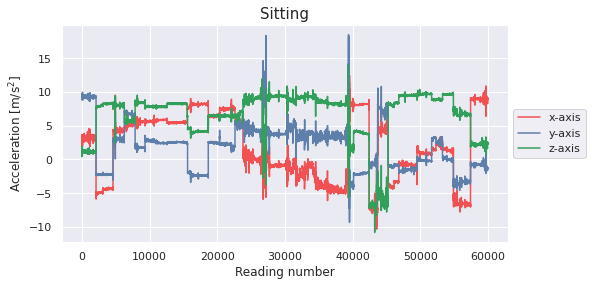

In [17]:
plot_example('Sitting', raw, start=0, end=None)

Even for a simple activity such as sitting there are different patterns for different users.

In the original paper, this raw data was divided into 10-second segments (200 readings). For each segment, different features were generated. Here is the transformed dataset:

In [18]:
data = arff.loadarff('data/WISDM_ar_v1.1_transformed.arff')
trans = pd.DataFrame(data[0]).sample(frac=1)
trans.head()

,UNIQUE_ID,user,X0,X1,X2,X3,X4,X5,X6,X7,...,YPEAK,ZPEAK,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,RESULTANT,class
5194,163.0,b'19',0.07,0.09,0.11,0.10,0.09,0.10,0.10,0.14,...,800.00,2025.00,9.28,6.41,2.39,11.75,8.15,11.75,12.59,b'Jogging'
4440,306.0,b'17',0.08,0.09,0.11,0.09,0.09,0.11,0.13,0.11,...,2416.67,3183.33,0.96,1.98,1.08,1.25,2.48,1.25,10.38,b'Upstairs'
1678,288.0,b'11',0.05,0.13,0.19,0.18,0.23,0.20,0.04,0.01,...,600.00,1833.33,1.97,3.25,2.80,2.73,3.87,2.73,10.92,b'Walking'
283,284.0,b'33',0.16,0.11,0.14,0.09,0.08,0.15,0.10,0.09,...,1250.00,1550.00,2.11,3.42,2.13,2.79,4.08,2.79,10.63,b'Walking'
598,599.0,b'13',0.10,0.09,0.06,0.15,0.14,0.10,0.10,0.07,...,363.04,1450.00,4.24,8.19,7.64,5.39,9.60,5.39,14.32,b'Jogging'


In [19]:
trans['user'] = trans['user'].apply(lambda x: x.decode("utf-8"))
trans['class'] = trans['class'].apply(lambda x: x.decode("utf-8"))

Again I check if there are any missing values.

In [20]:
trans.isna().sum()[trans.isna().sum()>0]

XPEAK    381
YPEAK    131
ZPEAK    103
dtype: int64

I substitute the missing values with the average values of their respective columns. 

In [21]:
trans.fillna(trans.mean(), inplace=True)

Let's see an example of what the transformed data looks like.

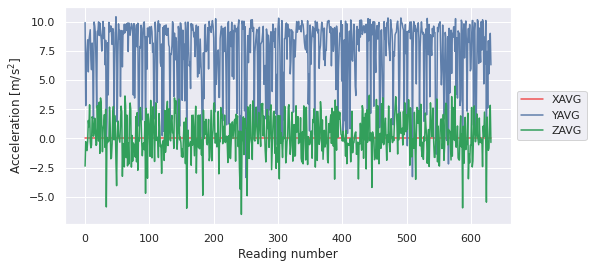

In [22]:
data = trans[trans['class'] == 'Upstairs'][['XAVG', 'YAVG', 'ZAVG']].reset_index()
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(data['XAVG'],color=colours[0], label='XAVG')
ax.plot(data['YAVG'],color=colours[1], label='YAVG')
ax.plot(data['ZAVG'],color=colours[2], label='ZAVG')
ax.set_xlabel('Reading number')
ax.set_ylabel('Acceleration [m/s$^2$]')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

There seems to be a problem with this transformed dataset as the average value for the x-axis is zero for every example.

In [23]:
trans['XAVG'].unique()

array([0.])

## Reproducing the paper's results

Ignoring this problem with their transformed data, I try to reproduce their results for logistic regression and decision trees models.  The paper's results obtained using ten-fold cross validation were:

- **Logistic regression**: overall accuracy of 78.1%.
- **Decision tree**: overall accuracy of 85.1%

In [24]:
X = trans.drop(['UNIQUE_ID','user','class','XAVG'],axis=1)
y = trans['class']

X_mean = X.mean()
X_std = X.std()

X = (X - X_mean) / X_std

In [25]:
lr = LogisticRegression(max_iter=5000)
scores = cross_val_score(lr, X, y, cv=10)
print('Logistic regression: overall accuracy of (%0.f +/- %0.f)%%.' % (scores.mean()*100, 2*scores.std()*100))

Logistic regression: overall accuracy of (79 +/- 2)%.


In [26]:
dtree = DecisionTreeClassifier()
scores = cross_val_score(dtree, X, y, cv=10)
print('Decisition tree: overall accuracy of (%0.f +/- %0.f)%%.' % (scores.mean()*100, 2*scores.std()*100))

Decisition tree: overall accuracy of (85 +/- 1)%.


Even with a problem in one of the transformed dataset's columns, their results were reproduced. 

## Feature generation

Here I generate features to be used in the learning algorithms from the raw dataset. The data is divided in groups of 200 raw accelerometer readings containing values corresponding to the three axes. Then the following features are calculated:

- Mean acceleration for each axis.
- Standard deviation for each axis.
- Correlation beatween the axes.
- Average of the resultant acceleration $\sqrt{a_x^2+a_y^2+a_z^2}$.
- Standard deviation of the resultant acceleration.

In [27]:
df = pd.DataFrame(columns=['user','x_mean','x_std','y_mean','y_std','z_mean','z_std','xy','xz','yz',
                                 'a_mean','a_std','activity'])

In [28]:
unique_id = 0
for user in raw['user'].unique():
    for activity in raw['activity'].unique():
        data = raw[(raw['user']==user) & (raw['activity']==activity)].reset_index()
        num = data.shape[0]//200
        for i in range(num):
            df.loc[unique_id, 'user'] = user
            df.loc[unique_id, 'activity'] = activity
            temp_x = data['x-axis'][i*200:(i+1)*200]
            temp_y = data['y-axis'][i*200:(i+1)*200]
            temp_z = data['z-axis'][i*200:(i+1)*200]
            df.loc[unique_id, 'x_mean'] = temp_x.mean()
            df.loc[unique_id, 'x_std'] = temp_x.std()
            df.loc[unique_id, 'y_mean'] = temp_y.mean()
            df.loc[unique_id, 'y_std'] = temp_y.std()
            df.loc[unique_id, 'z_mean'] = temp_z.mean()
            df.loc[unique_id, 'z_std'] = temp_z.std()
            df.loc[unique_id, 'xy'] = np.correlate(temp_x,temp_y)[0]
            df.loc[unique_id, 'xz'] = np.correlate(temp_x,temp_z)[0]
            df.loc[unique_id, 'yz'] = np.correlate(temp_y,temp_z)[0]
            acceleration = np.sqrt(np.square(temp_x)+np.square(temp_y)+np.square(temp_z))
            df.loc[unique_id, 'a_mean'] = acceleration.mean()
            df.loc[unique_id, 'a_std'] = acceleration.std()
            unique_id += 1

In [29]:
df.head()

,user,x_mean,x_std,y_mean,y_std,z_mean,z_std,xy,xz,yz,a_mean,a_std,activity
0,33,-0.169233,4.05977,8.40437,8.18868,1.7605,5.08406,-1014.29,271.053,6702.69,11.9564,6.31198,Jogging
1,33,-0.697702,5.39476,7.61793,8.20762,1.42789,5.39877,-3389.34,-666.695,6751.78,12.0545,6.35908,Jogging
2,33,-1.22522,5.37985,7.90913,8.15127,2.44581,5.41597,-4485.48,-1963.49,8269.68,12.1323,6.86842,Jogging
3,33,1.84597,5.44707,8.9579,7.74652,1.68368,5.00348,5379.51,2822.66,6927.02,12.9168,5.82684,Jogging
4,33,2.24688,6.43109,9.9989,7.61039,1.51989,4.47108,6199.55,2463.98,5764.41,13.8876,5.77139,Jogging


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5406 entries, 0 to 5405
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user      5406 non-null   object
 1   x_mean    5406 non-null   object
 2   x_std     5406 non-null   object
 3   y_mean    5406 non-null   object
 4   y_std     5406 non-null   object
 5   z_mean    5406 non-null   object
 6   z_std     5406 non-null   object
 7   xy        5406 non-null   object
 8   xz        5406 non-null   object
 9   yz        5406 non-null   object
 10  a_mean    5406 non-null   object
 11  a_std     5406 non-null   object
 12  activity  5406 non-null   object
dtypes: object(13)
memory usage: 751.3+ KB


In [31]:
df = pd.concat([pd.DataFrame([pd.to_numeric(df[e],errors='coerce') \
                               for e in df.columns if e not in ['activity']]).T,
                 df['activity']],axis=1)

There are no missing values:

In [32]:
df.isna().sum()

user        0
x_mean      0
x_std       0
y_mean      0
y_std       0
z_mean      0
z_std       0
xy          0
xz          0
yz          0
a_mean      0
a_std       0
activity    0
dtype: int64

This new dataset is scaled and split into training and test sets in a 0.7:0.3 ratio.

In [33]:
X = df.drop(['user','activity'],axis=1)
y = df['activity']

X_train = X.sample(frac=0.8,random_state=0)
X_test = X.drop(X_train.index)

y_train = y[X_train.index]
y_test = y[X_test.index]

X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

## Naive Bayes

I use a Gaussian Naive Bayes as a baseline model.

In [34]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictions = gnb.predict(X_test)

I define a function to plot the normalised confusion matrix, which I'll use for every algorithm.

In [35]:
def plot_cm(y, y_test, predictions):
    labels = np.sort(y.unique())
    cm = confusion_matrix(y_test, predictions)
    cmn = cm/cm.sum(axis=0)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    return cmn

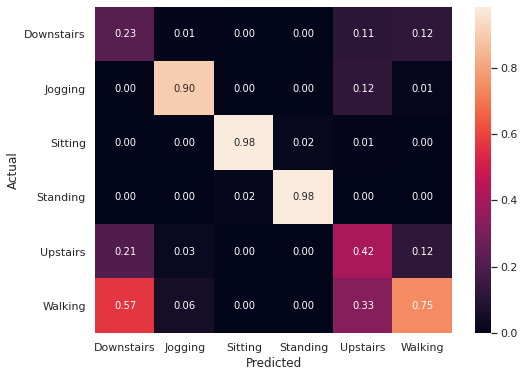

In [36]:
cmn_gnb = plot_cm(y, y_test, predictions)

In [37]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.23      0.26      0.24        89
     Jogging       0.90      0.95      0.93       343
     Sitting       0.98      0.96      0.97        56
    Standing       0.98      0.98      0.98        47
    Upstairs       0.42      0.33      0.37       122
     Walking       0.75      0.74      0.74       424

    accuracy                           0.74      1081
   macro avg       0.71      0.70      0.70      1081
weighted avg       0.74      0.74      0.74      1081



In [38]:
test_accuracy_gnb = gnb.score(X_test,y_test)
print('Naive Bayes: test accuracy of %0.1f%%.' % (100*test_accuracy_gnb))

Naive Bayes: test accuracy of 74.3%.


As expected the accuracy of this algorithm is not impressive. However it should be noted that it has done a good job classifying the sitting and standing activities, with not much confusion between them. It has perfomed poorly for the ascending and descending stairs activities, confusing them with other periodic activities such as walking.

## Logistic regression

Let's check how a logisitic regression model performs.

In [39]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)

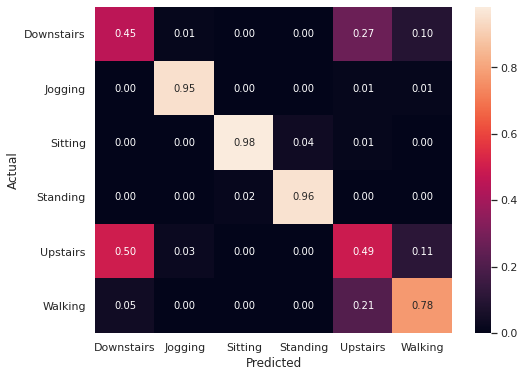

In [40]:
cmn_lr = plot_cm(y, y_test, predictions)

In [41]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.45      0.11      0.18        89
     Jogging       0.95      0.98      0.97       343
     Sitting       0.98      0.95      0.96        56
    Standing       0.96      0.98      0.97        47
    Upstairs       0.49      0.34      0.41       122
     Walking       0.78      0.95      0.86       424

    accuracy                           0.82      1081
   macro avg       0.77      0.72      0.72      1081
weighted avg       0.79      0.82      0.79      1081



In [42]:
test_accuracy_lr = lr.score(X_test,y_test)
print('Logistic regression: test accuracy of %0.1f%%.' % (100*test_accuracy_lr))

Logistic regression: test accuracy of 82.3%.


Logistic regression performs a bit better than Naive Bayes.

## Decision tree

Now I'll try a decision tree model, which can capture non-linearities.

In [43]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)

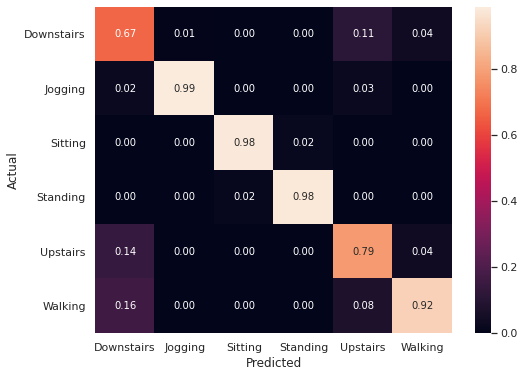

In [44]:
cmn_dtree = plot_cm(y, y_test, predictions)

In [45]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.67      0.64      0.66        89
     Jogging       0.99      0.99      0.99       343
     Sitting       0.98      0.98      0.98        56
    Standing       0.98      0.98      0.98        47
    Upstairs       0.79      0.75      0.77       122
     Walking       0.92      0.94      0.93       424

    accuracy                           0.91      1081
   macro avg       0.89      0.88      0.88      1081
weighted avg       0.91      0.91      0.91      1081



In [46]:
test_accuracy_dtree = dtree.score(X_test,y_test)
print('Logistic regression: test accuracy of %0.1f%%.' % (100*test_accuracy_dtree))

Logistic regression: test accuracy of 91.4%.


This decision tree has done a better job at recognising the stairs activities.

## Random forest

This result can be improved using a random forest classifier.

In [47]:
error = []

min_estimators = 30
max_estimators = 500

for i in range(min_estimators, max_estimators + 10, 10):
    rfc = RandomForestClassifier(n_estimators=i, oob_score=True)
    rfc.fit(X_train,y_train)
    oob_error = 1 - rfc.oob_score_
    error.append(oob_error)

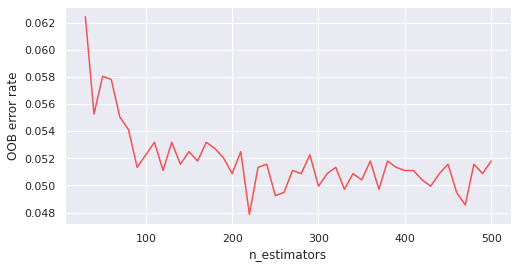

In [48]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(range(min_estimators, max_estimators + 10, 10), error, c=colours[0])
ax.set_ylabel('OOB error rate')
ax.set_xlabel('n_estimators');

In [49]:
rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

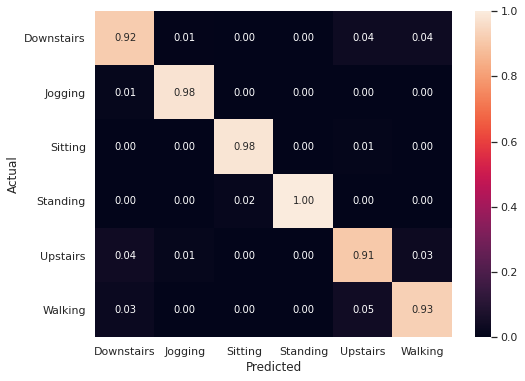

In [50]:
cmn_rfc = plot_cm(y, y_test, predictions)

In [51]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.92      0.74      0.82        89
     Jogging       0.98      0.99      0.99       343
     Sitting       0.98      0.98      0.98        56
    Standing       1.00      0.98      0.99        47
    Upstairs       0.91      0.81      0.86       122
     Walking       0.93      0.98      0.95       424

    accuracy                           0.95      1081
   macro avg       0.95      0.92      0.93      1081
weighted avg       0.95      0.95      0.95      1081



In [52]:
test_accuracy_rfc = rfc.score(X_test,y_test)
print('Random forest classifier: test accuracy of %0.1f%%.' % (100*test_accuracy_rfc))

Random forest classifier: test accuracy of 94.7%.


## K-nearest neighbours

Finally, before moving to neural networks, I use the k-nearest neighbours algorithm.

In [53]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)

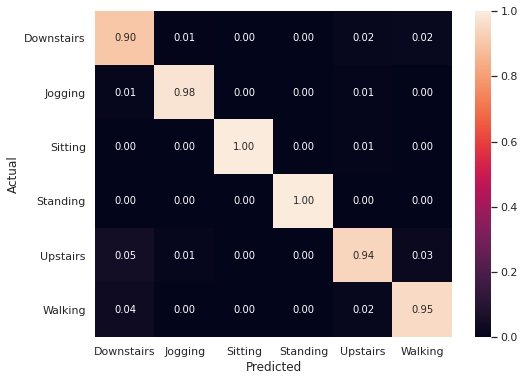

In [54]:
cmn_knn = plot_cm(y, y_test, predictions)

In [55]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Downstairs       0.90      0.85      0.88        89
     Jogging       0.98      0.99      0.99       343
     Sitting       1.00      0.98      0.99        56
    Standing       1.00      1.00      1.00        47
    Upstairs       0.94      0.84      0.89       122
     Walking       0.95      0.99      0.97       424

    accuracy                           0.96      1081
   macro avg       0.96      0.94      0.95      1081
weighted avg       0.96      0.96      0.96      1081



In [56]:
test_accuracy_knn = knn.score(X_test,y_test)
print('K-nearest neighbours: test accuracy of %0.1f%%.' % (100*test_accuracy_knn))

K-nearest neighbours: test accuracy of 96.2%.


The precision for the stairs activities is the highest so far.

## Feedforward neural network

Here the the training set is split again to create a validation set.

In [57]:
X_train_0 = X_train

X_train = X_train_0.sample(frac=0.75,random_state=0)
X_val = X_train_0.drop(X_train.index)

y_train = y[X_train.index]
y_val = y[X_val.index]

X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

The labels are one-hot encoded:

In [58]:
y_train_e= pd.get_dummies(y_train)
y_val_e = pd.get_dummies(y_val)
y_test_e = pd.get_dummies(y_test)

Now I create the TensorFlow datasets:

In [59]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_e))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_e))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_e))

The model is built with one densely connected hidden layer of 14 neurons.

In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation=tf.nn.relu),
    tf.keras.layers.Dense(15, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

I use the adam optimiser and categorical cross entropy as the loss function.

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

The model is trained using batches of size 10.

In [62]:
BATCH_SIZE = 10
train_batch = train_dataset.cache().repeat().shuffle(X_train.shape[0]).batch(BATCH_SIZE)
val_batch = val_dataset.cache().repeat().shuffle(X_val.shape[0]).batch(BATCH_SIZE)
test_batch = test_dataset.cache().repeat().batch(BATCH_SIZE)

In [63]:
EPOCHS = 200

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(
    train_batch, epochs=EPOCHS, 
    steps_per_epoch=np.ceil(X_train.shape[0]/BATCH_SIZE),
    validation_data=val_batch, verbose=2, callbacks=early_stop,
    validation_steps=np.ceil(X_val.shape[0]/BATCH_SIZE))

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

325/325 - 1s - loss: 1.2203 - accuracy: 0.5209 - val_loss: 0.8875 - val_accuracy: 0.6862
Epoch 2/200
325/325 - 0s - loss: 0.7365 - accuracy: 0.7188 - val_loss: 0.6460 - val_accuracy: 0.7468
Epoch 3/200
325/325 - 0s - loss: 0.5988 - accuracy: 0.7655 - val_loss: 0.5682 - val_accuracy: 0.7761
Epoch 4/200
325/325 - 0s - loss: 0.5182 - accuracy: 0.7988 - val_loss: 0.5148 - val_accuracy: 0.8101
Epoch 5/200
325/325 - 0s - loss: 0.4931 - accuracy: 0.8166 - val_loss: 0.4902 - val_accuracy: 0.8119
Epo

The accuracies for both the training and validation are plotted below.

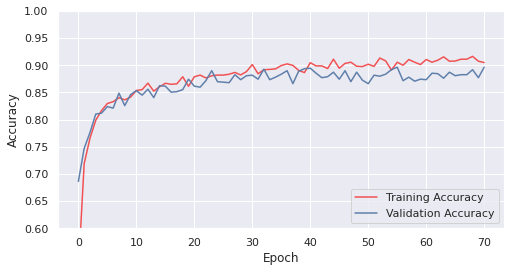

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(len(acc))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epochs_range, acc, c=colours[0], label='Training Accuracy')
ax.plot(epochs_range, val_acc, c=colours[1], label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_ylim(0.6,1)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch');

The accuracy on the training set is:

In [65]:
test_loss_fnn, test_accuracy_fnn = model.evaluate(test_batch, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
print('Feedforward neural network: test accuracy of %0.1f%%.' % (100*test_accuracy_fnn))

109/109 [==============================] - 0s 1ms/step - loss: 0.2826 - accuracy: 0.8881
Feedforward neural network: test accuracy of 88.8%.


The confusion matrix is plotted below.

In [66]:
predictions = model.predict(test_dataset.batch(1))

In [67]:
predictions_m = np.zeros((predictions.shape[0],6))
predictions_m[np.arange(predictions.shape[0]), predictions.argmax(1)] = 1 

In [68]:
cm = confusion_matrix(np.argmax(y_test_e.values,axis=1), np.argmax(predictions_m,axis=1))

Text(0.5, 30.5, 'Predicted')

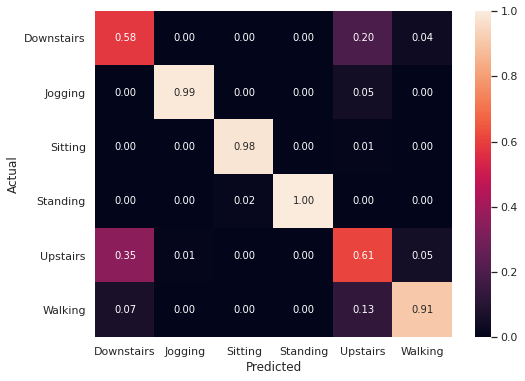

In [69]:
labels = np.sort(y.unique())
cmn_fnn = cm/cm.sum(axis=0)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn_fnn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [70]:
print(classification_report(y_test_e,predictions_m))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58        89
           1       0.99      0.98      0.99       343
           2       0.98      0.98      0.98        56
           3       1.00      0.98      0.99        47
           4       0.61      0.53      0.57       122
           5       0.91      0.95      0.93       424

   micro avg       0.89      0.89      0.89      1081
   macro avg       0.85      0.84      0.84      1081
weighted avg       0.88      0.89      0.88      1081
 samples avg       0.89      0.89      0.89      1081



## Convolutional neural network

The convolutional neural network is trained on the raw 10-second segments (200 readings).

In [71]:
segment_x = []
segment_y = []
segment_z = []
y = []
for user in raw['user'].unique():
    for activity in raw['activity'].unique():
        data = raw[(raw['user']==user) & (raw['activity']==activity)].reset_index()
        num = data.shape[0]//200
        for i in range(num):
            segment_x.append(data['x-axis'][i*200:(i+1)*200].values)
            segment_y.append(data['y-axis'][i*200:(i+1)*200].values)
            segment_z.append(data['z-axis'][i*200:(i+1)*200].values)
            y.append(activity)

In [72]:
segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_z = np.array(segment_z)

In [73]:
X = np.dstack((segment_x, segment_y, segment_z))
X.shape

(5406, 200, 3)

In [74]:
y = np.asarray(y)
y.shape

(5406,)

Here the dataset is split into training, validation and test sets.

In [75]:
X_train = X[X_train.index]
y_train = y[y_train.index]
X_val = X[X_val.index]
y_val = y[y_val.index]
X_test = X[X_test.index]
y_test = y[y_test.index]

The labels are one-hot encoded:

In [76]:
y_train_e = pd.get_dummies(y_train)
y_val_e = pd.get_dummies(y_val)
y_test_e = pd.get_dummies(y_test)

Now I create the TensorFlow datasets:

In [77]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_e))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_e))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_e))

The model consists of two convolution blocks with a max pool layer in each of them. Before the final dense layers, there is a dropout probability of 0.5. Then there is a fully connected layer with 128 units. The model will output class probabilities for the six activities using softmax.

In [78]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation=tf.nn.relu, input_shape=(200, 3)),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Conv1D(128, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [80]:
BATCH_SIZE = 10
train_batch = train_dataset.cache().repeat().shuffle(X_train.shape[0]).batch(BATCH_SIZE)
val_batch = val_dataset.cache().repeat().shuffle(X_val.shape[0]).batch(BATCH_SIZE)
test_batch = test_dataset.cache().repeat().batch(BATCH_SIZE)

In [81]:
EPOCHS = 20

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_batch, epochs=EPOCHS, 
    steps_per_epoch=np.ceil(X_train.shape[0]/BATCH_SIZE), callbacks=early_stop,
    validation_data=val_batch, verbose=2, validation_steps=np.ceil(X_val.shape[0]/BATCH_SIZE))

Epoch 1/20
325/325 - 4s - loss: 0.7978 - accuracy: 0.7462 - val_loss: 0.4276 - val_accuracy: 0.8440
Epoch 2/20
325/325 - 3s - loss: 0.3848 - accuracy: 0.8637 - val_loss: 0.3250 - val_accuracy: 0.8771
Epoch 3/20
325/325 - 3s - loss: 0.2630 - accuracy: 0.9003 - val_loss: 0.2899 - val_accuracy: 0.8936
Epoch 4/20
325/325 - 3s - loss: 0.1955 - accuracy: 0.9308 - val_loss: 0.2422 - val_accuracy: 0.9110
Epoch 5/20
325/325 - 3s - loss: 0.1602 - accuracy: 0.9428 - val_loss: 0.1986 - val_accuracy: 0.9165
Epoch 6/20
325/325 - 3s - loss: 0.1150 - accuracy: 0.9612 - val_loss: 0.1878 - val_accuracy: 0.9266
Epoch 7/20
325/325 - 3s - loss: 0.1012 - accuracy: 0.9686 - val_loss: 0.5371 - val_accuracy: 0.8431
Epoch 8/20
325/325 - 3s - loss: 0.1271 - accuracy: 0.9631 - val_loss: 0.2426 - val_accuracy: 0.9294
Epoch 9/20
325/325 - 3s - loss: 0.0728 - accuracy: 0.9760 - val_loss: 0.1946 - val_accuracy: 0.9413
Epoch 10/20
325/325 - 3s - loss: 0.0647 - accuracy: 0.9738 - val_loss: 0.2350 - val_accuracy: 0.9339

The accuracies for both the training and validation are plotted below.

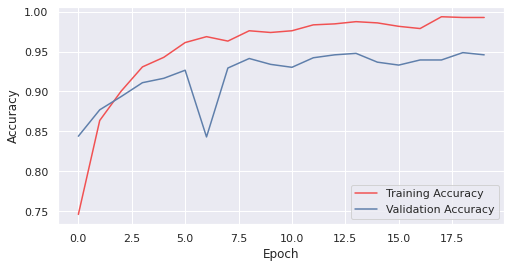

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(len(acc))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epochs_range, acc, c=colours[0], label='Training Accuracy')
ax.plot(epochs_range, val_acc, c=colours[1], label='Validation Accuracy')
ax.legend(loc='lower right')
#ax.set_ylim(0.6,1)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch');

The accuracy on the training set is:

In [83]:
test_loss_cnn, test_accuracy_cnn = model.evaluate(test_batch, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
print('Feedforward neural network: test accuracy of %0.1f%%.' % (100*test_accuracy_cnn))

109/109 [==============================] - 0s 3ms/step - loss: 0.2791 - accuracy: 0.9440
Feedforward neural network: test accuracy of 94.4%.


The confusion matrix is plotted below.

In [84]:
predictions = model.predict(test_dataset.batch(1))

In [85]:
pred = np.zeros((predictions.shape[0],6))
pred[np.arange(predictions.shape[0]), predictions.argmax(1)] = 1 

In [86]:
cm = confusion_matrix(np.argmax(y_test_e.values,axis=1), np.argmax(pred,axis=1))

Text(0.5, 30.5, 'Predicted')

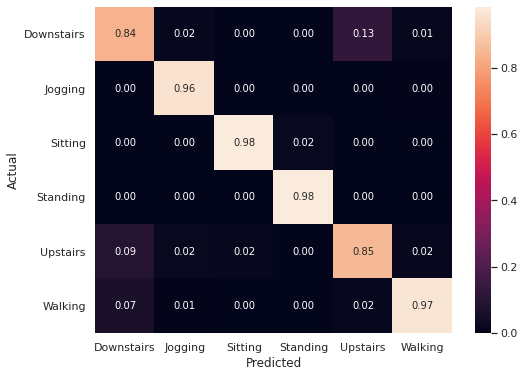

In [87]:
labels = np.sort(np.unique(y))
cmn_cnn = cm/cm.sum(axis=0)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn_cnn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [88]:
print(classification_report(y_test_e,pred))

              precision    recall  f1-score   support

           0       0.84      0.70      0.76        89
           1       0.96      0.99      0.98       343
           2       0.98      0.98      0.98        56
           3       0.98      1.00      0.99        47
           4       0.85      0.82      0.84       122
           5       0.97      0.98      0.97       424

   micro avg       0.94      0.94      0.94      1081
   macro avg       0.93      0.91      0.92      1081
weighted avg       0.94      0.94      0.94      1081
 samples avg       0.94      0.94      0.94      1081



## Conclusion

The table below shows the accuracy for each algorithm and their precision for the stairs activities (similar activities often confused with each other).

In [89]:
results = {'Test accuracy (%)': [np.round(test_accuracy_gnb,3)*100,
                                np.round(test_accuracy_lr,3)*100,
                                np.round(test_accuracy_dtree,3)*100,
                                np.round(test_accuracy_rfc,3)*100,
                                np.round(test_accuracy_knn,3)*100,
                                np.round(test_accuracy_fnn,3)*100,
                                np.round(test_accuracy_cnn,3)*100],
           
           'Upstairs precision (%)': [np.round(cmn_gnb[0,0],3)*100,
                                  np.round(cmn_lr[0,0],3)*100,
                                  np.round(cmn_dtree[0,0],3)*100,
                                  np.round(cmn_rfc[0,0],3)*100,
                                  np.round(cmn_knn[0,0],3)*100,
                                  np.round(cmn_fnn[0,0],3)*100,
                                  np.round(cmn_cnn[0,0],3)*100],
           
           'Downstairs precision (%)': [np.round(cmn_gnb[4,4],3)*100,
                                  np.round(cmn_lr[4,4],3)*100,
                                  np.round(cmn_dtree[4,4],3)*100,
                                  np.round(cmn_rfc[4,4],3)*100,
                                  np.round(cmn_knn[4,4],3)*100,
                                  np.round(cmn_fnn[4,4],3)*100,
                                  np.round(cmn_cnn[4,4],3)*100],
        }

table = pd.DataFrame(results, columns = ['Test accuracy (%)','Upstairs precision (%)','Downstairs precision (%)'], index=['Naive Bayes','Logistic regression', 'Decision tree', 'Random forest' ,'K-nearest neighbours', 'Feedforward neural network', 'Convolutional neural network'])
table

,Test accuracy (%),Upstairs precision (%),Downstairs precision (%)
Naive Bayes,74.3,22.5,41.7
Logistic regression,82.3,45.5,49.4
Decision tree,91.4,67.1,78.6
Random forest,94.7,91.7,90.8
K-nearest neighbours,96.2,90.5,94.4
Feedforward neural network,88.8,58.4,61.3
Convolutional neural network,94.4,83.8,85.5
